In [411]:
import os
from pprint import pprint

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

import random
import string

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
import optuna

import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from eli5.sklearn import PermutationImportance

In [412]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [413]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [414]:
# divide
dam = train.filter(regex='_Dam')
fill1 = train.filter(regex='_Fill1')
fill2 = train.filter(regex='_Fill2')
autoclave = train.filter(regex='_AutoClave')
target = train['target']

# dam
dam = dam.dropna(axis=1, how='all')
dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
dam = dam.drop(columns='WorkMode Collect Result_Dam')

# fill1
fill1 = fill1.dropna(axis=1, how='all')
fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

# fill2
fill2 = fill2.dropna(axis=1, how='all')
fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

# CONCAT
train = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)

# divide
dam_test = test.filter(regex='_Dam')
fill1_test = test.filter(regex='_Fill1')
fill2_test = test.filter(regex='_Fill2')
autoclave_test = test.filter(regex='_AutoClave')

# dam
dam_test = dam_test.dropna(axis=1, how='all')
dam_test = dam_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
dam_mask_test = dam_test[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
dam_test.loc[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam_test.columns[24:]] = dam_mask_test
dam_test = dam_test.drop(columns='WorkMode Collect Result_Dam')

# fill1
fill1_test = fill1_test.dropna(axis=1, how='all')
fill1_test = fill1_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
fill1_mask_test = fill1_test[fill1_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
fill1_test.loc[fill1_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1_test.columns[14:]] = fill1_mask_test
fill1_test = fill1_test.drop(columns='WorkMode Collect Result_Fill1')

# fill2
fill2_test = fill2_test.dropna(axis=1, how='all')
fill2_test = fill2_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
fill2_mask_test = fill2_test[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
fill2_test.loc[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2_test.columns[24:]] = fill2_mask_test
fill2_test = fill2_test.drop(columns='WorkMode Collect Result_Fill2')

# CONCAT
test = pd.concat([dam_test, fill1_test, fill2_test, autoclave_test], axis=1)

/tmp/ipykernel_55/3265365813.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_55/3265365813.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_55/3265365813.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '

In [415]:
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df


# 조건을 만족하는 행 인덱스를 찾음
condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

# DISCHARGED TIME OF RESIN(Stage1) 
swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

# Dispense Volume(Stage1)
swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

# HEAD NORMAL COORDINATE Y AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

# HEAD NORMAL COORDINATE Z AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

# Stage1 Circle1 Distance Speed Collect
swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

# Stage1 Line1 Distance Speed Collect
swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

# THICKNESS 1
# swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

### 젤 마지막에 와야됨!!!!
# HEAD NORMAL COORDINATE X AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')



# 조건을 만족하는 행 인덱스를 찾음
condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

# DISCHARGED TIME OF RESIN(Stage1)
swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

# Dispense Volume(Stage1)
swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Y AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Z AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

# 반드시 마지막으로 와야함!!!!
# HEAD NORMAL COORDINATE X AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')


condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

# DISCHARGED TIME OF RESIN(Stage1)
swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

# Dispense Volume(Stage1)
swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Y AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Z AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

# 반드시 마지막으로 와야함!!!!
# HEAD NORMAL COORDINATE X AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

/tmp/ipykernel_55/2983827387.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[162.4, '162.4', 162.7, 162.4, 161.7, 164.2, 162.4, 162.4, 164.2, 161.2, 162.7, 162.7, 162.4, 162.4, '162.4', 164.2, 164.2, '162.4', 162.4, 163.8, 161.2, '162.4', 162.4, 161.2, 163.8, 162.7, 162.4, 163.5, 162.4, 162.7, 162.4, 162.4, '162.4', 162.7, 162.4, 164.1, 164.2, 162.7, 164.0, 164.2, 163.3, 164.2, 162.4, 163.7, 161.7, 162.4, 162.7, 162.7, 164.2, 163.5, 163.3, 162.4, '162.4', 161.7, '162.4', 162.4, 162.4, 162.4, 162.4, 162.7, '162.4', '162.4', 163.5, 163.5, 162.4, '162.4', 162.4, '162.4', 164.2, 161.2, 162.4, 162.4, '162.4', 163.8, 162.4, '162.4', 164.2, 164.1, '162.4', 161.7, 163.7, 162.7, 164.2, '162.4', 162.7, 164.2, 162.4, 164.2, 163.3, 164.2, 162.7, 162.4, '162.4', 162.4, 164.2, 162.7, 162.4, 163.5, 162.7, 162.7, 162.4, '162.4', '162.4', 162.7, 161.7, 162.7, 161.2, 162.7, 162.7, 162.4, 164.2, '162.4', '162.4', 162.4, 162.4, 1

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,3rd Pressure Judge Value_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,0.499,120,OK,54,361,OK,NaN,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,0.498,121,OK,54,483,OK,NaN,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,0.498,121,OK,56,363,OK,OK,NaN,OK,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,0.500,121,OK,54,483,OK,NaN,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,0.498,120,OK,47,480,NG,NaN,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,0.500,121,OK,54,483,OK,NaN,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,0.498,120,OK,49,361,NG,NaN,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,0.498,121,OK,48,363,NG,OK,NaN,OK,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,0.499,121,OK,54,483,OK,NaN,NaN,NaN,Normal


In [416]:
df_train = train
df_test = test

# New Column

In [417]:
train = df_train
test = df_test
train['Equipment_Dam'] = train['Equipment_Dam'].str.slice(15, 16)
train['Equipment_Fill1'] = train['Equipment_Fill1'].str.slice(17, 18)
train['Equipment_Fill2'] = train['Equipment_Fill2'].str.slice(17, 18)

test['Equipment_Dam'] = test['Equipment_Dam'].str.slice(15, 16)
test['Equipment_Fill1'] = test['Equipment_Fill1'].str.slice(17, 18)
test['Equipment_Fill2'] = test['Equipment_Fill2'].str.slice(17, 18)
df_train = train
df_test = test

In [418]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)
    
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [419]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

In [420]:
# 유클리드 거리 계산
def euclide_distance(data, first_dot, second_dot):
    
    # 값 반환
    iwantcalculateeuclidedistance = np.array([0]*len(data))
    
    # 제곱값 더해주기
    for i, j in zip(first_dot, second_dot):
        iwantcalculateeuclidedistance += (data[i] - data[j])**2
        
    # 반환
    return iwantcalculateeuclidedistance**0.5

In [421]:
# dam , fill1
first_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'
]

second_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
]

df_train[first_dot] = df_train[first_dot].astype(float)
df_train[second_dot] = df_train[second_dot].astype(float)
df_test[first_dot] = df_test[first_dot].astype(float)
df_test[second_dot] = df_test[second_dot].astype(float)

# 유클리드 계산을 통한 위치 차이
df_train['distance_diff_dam_fill1_stage1'] = euclide_distance(df_train, first_dot, second_dot)
df_test['distance_diff_dam_fill1_stage1'] = euclide_distance(df_test, first_dot, second_dot)

In [422]:
# dam , fill1
first_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'
]

second_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
]

df_train[first_dot] = df_train[first_dot].astype(float)
df_train[second_dot] = df_train[second_dot].astype(float)
df_test[first_dot] = df_test[first_dot].astype(float)
df_test[second_dot] = df_test[second_dot].astype(float)

# 유클리드 계산을 통한 위치 차이
df_train['distance_diff_dam_fill1_stage2'] = euclide_distance(df_train, first_dot, second_dot)
df_test['distance_diff_dam_fill1_stage2'] = euclide_distance(df_test, first_dot, second_dot)

In [423]:
# dam, fill1
first_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
]

second_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
]

df_train[first_dot] = df_train[first_dot].astype(float)
df_train[second_dot] = df_train[second_dot].astype(float)
df_test[first_dot] = df_test[first_dot].astype(float)
df_test[second_dot] = df_test[second_dot].astype(float)

# 유클리드 계산을 통한 위치 차이
df_train['distance_diff_dam_fill1_stage3'] = euclide_distance(df_train, first_dot, second_dot)
df_test['distance_diff_dam_fill1_stage3'] = euclide_distance(df_test, first_dot, second_dot)

### Cure

In [424]:
# start, end
first_dot = [
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Z Collect Result_Dam'
]

second_dot = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam'
]

df_train[first_dot] = df_train[first_dot].astype(float)
df_train[second_dot] = df_train[second_dot].astype(float)
df_test[first_dot] = df_test[first_dot].astype(float)
df_test[second_dot] = df_test[second_dot].astype(float)

# 유클리드 계산을 통한 위치 차이
df_train['dist_start_end_cure_dam'] = euclide_distance(df_train, first_dot, second_dot)
df_test['dist_start_end_cure_dam'] = euclide_distance(df_test, first_dot, second_dot)

# cure_time # 유효
df_train['cure_time_dam'] = df_train['dist_start_end_cure_dam'] / df_train['CURE SPEED Collect Result_Dam']
df_test['cure_time_dam'] = df_test['dist_start_end_cure_dam'] / df_test['CURE SPEED Collect Result_Dam']

# 만든 후 제거한다.
df_train = df_train.drop(columns = ['dist_start_end_cure_dam'])
df_test = df_test.drop(columns = ['dist_start_end_cure_dam'])

In [425]:
# 계산전 전처리
df_train[df_train['CURE END POSITION X Collect Result_Fill2'] == 1020]['CURE END POSITION X Collect Result_Fill2'] = 240
df_train[df_train['CURE START POSITION X Collect Result_Fill2'] == 240]['CURE START POSITION X Collect Result_Fill2'] = 1020

# start, end
first_dot = [
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2'
]

second_dot = [
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2'
]

df_train[first_dot] = df_train[first_dot].astype(float)
df_train[second_dot] = df_train[second_dot].astype(float)
df_test[first_dot] = df_test[first_dot].astype(float)
df_test[second_dot] = df_test[second_dot].astype(float)

# 유클리드 계산을 통한 위치 차이
df_train['dist_start_end_cure_fill2'] = euclide_distance(df_train, first_dot, second_dot)
df_test['dist_start_end_cure_fill2'] = euclide_distance(df_test, first_dot, second_dot)

# cure_time
df_train['cure_time_fill2'] = df_train['dist_start_end_cure_fill2'] / df_train['CURE SPEED Collect Result_Fill2']
df_test['cure_time_fill2'] = df_test['dist_start_end_cure_fill2'] / df_test['CURE SPEED Collect Result_Fill2']

# 만든 후 제거한다.
df_train = df_train.drop(columns = ['dist_start_end_cure_fill2'])
df_test = df_test.drop(columns = ['dist_start_end_cure_fill2'])

/tmp/ipykernel_55/3852823698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[df_train['CURE END POSITION X Collect Result_Fill2'] == 1020]['CURE END POSITION X Collect Result_Fill2'] = 240
/tmp/ipykernel_55/3852823698.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[df_train['CURE START POSITION X Collect Result_Fill2'] == 240]['CURE START POSITION X Collect Result_Fill2'] = 1020


In [426]:
# press21
df_train['press21_autoclave'] = np.where(df_train['2nd Pressure Collect Result_AutoClave'] - df_train['1st Pressure Collect Result_AutoClave'] > 0.3, 1, 0)
df_test['press21_autoclave'] = np.where(df_test['2nd Pressure Collect Result_AutoClave'] - df_test['1st Pressure Collect Result_AutoClave'] > 0.3, 1, 0)

In [427]:
# thon time
df_train['thon_time'] = df_train['Machine Tact time Collect Result_Dam'] - df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] - train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] - df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
df_test['thon_time'] = df_test['Machine Tact time Collect Result_Dam'] - df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] - test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] - df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

In [428]:
# 75% 이상이면 1 아니면 0
# df_train['thon_time'] = np.where(df_train['thon_time'] >= 38.8, 1, 0)
# df_test['thon_time'] = np.where(df_test['thon_time'] >= 38.8, 1, 0)

In [429]:
# Discharged 거리
df_train['discharged_dist_stage1_dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_train['discharged_dist_stage2_dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_train['discharged_dist_stage3_dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

df_test['discharged_dist_stage1_dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_test['discharged_dist_stage2_dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_test['discharged_dist_stage3_dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

### AutoClave

In [430]:
# df_train['1st pressure'] = (1/df_train['1st Pressure_AutoClave']) * df_train['1st Pressure 1st Pressure Unit Time_AutoClave']
# df_train['2nd pressure'] = (1/df_train['2nd Pressure_AutoClave']) * df_train['2nd Pressure Unit Time_AutoClave']
# df_train['3rd pressure'] = (1/df_train['3rd Pressure_AutoClave']) * df_train['3rd Pressure Unit Time_AutoClave']

In [431]:
# workorder별로 불량률 계산
# a = pd.crosstab([df_train['Workorder_Dam'], df_train['Receip No Collect Result_Dam']], df_train['target']).reset_index()
# a['total'] = a['AbNormal'] + a['Normal']
# a['ratio'] = a['AbNormal'] / (a['total'])

# # 기준
# cri = [
#     (a['ratio'] == 0),
#     (a['ratio'] > 0.1)
# ]

# con = [
#     -1, 1
# ]

# a['select_workorder'] = np.select(cri, con, default = 0)

# # 결합 시킬 변수만 뽑기
# a2 = a[['Workorder_Dam', 'Receip No Collect Result_Dam', 'select_workorder']]

# # receip과 workorder 혼합
# df_train = pd.merge(df_train, a2, how = 'left', on = ['Workorder_Dam', 'Receip No Collect Result_Dam'])
# df_test = pd.merge(df_test, a2, how = 'left', on = ['Workorder_Dam', 'Receip No Collect Result_Dam'])

# # train에 정보가 없는 test는 기본 값인 0으로 채우기
# df_test['select_workorder'][df_test['select_workorder'].isna()] = 0

# Column Drop

In [432]:
df_test = df_test.drop(columns= [ 
 'Stage1 Circle2 Distance Speed Collect Result_Dam',
 'Stage1 Circle3 Distance Speed Collect Result_Dam',
 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
 'Stage2 Circle2 Distance Speed Collect Result_Dam',
 'Stage2 Circle3 Distance Speed Collect Result_Dam',
 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
 'Stage3 Circle2 Distance Speed Collect Result_Dam',
 'Stage3 Circle3 Distance Speed Collect Result_Dam',
 'Stage3 Circle4 Distance Speed Collect Result_Dam'] )

df_test = df_test.rename(columns={'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1 Circle Distance Speed_Dam', 
                                    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2 Circle Distance Speed_Dam',
                                    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3 Circle Distance Speed_Dam'})

# Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
df_test = df_test.drop(columns= [
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
])

df_test = df_test.rename(columns={'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2': 'HEAD NORMAL COORDINATE Z AXIS_Fill2', 
                                    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam': 'HEAD NORMAL COORDINATE Z AXIS_Dam',
                                    })

# Model.Suffix, Workorder이 같다.
df_test = df_test.drop(columns=['Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave'])
df_test = df_test.drop(columns=['Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave'])
df_test = df_test.rename(columns={'Workorder_Dam': 'Workorder', 'Model.Suffix_Dam': 'Model.Suffix'})

# 의미를 찾을 수 없는 컬럼들 제거
df_test = df_test.drop(columns=['Wip Line_Fill1', 
                                  'Process Desc._Fill1', 
                                  'Insp. Seq No._Fill1', 
                                  'Insp Judge Code_Fill1', 
                                  'Equipment_AutoClave',
                                  'Process Desc._AutoClave', 
                                  'Wip Line_AutoClave', 
                                  'Insp Judge Code_AutoClave',
                                  'Insp. Seq No._AutoClave',
                                  '1st Pressure Judge Value_AutoClave', 
                                  '2nd Pressure Judge Value_AutoClave', 
                                  '3rd Pressure Judge Value_AutoClave', 
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                                  'Wip Line_Fill2', 
                                  'Process Desc._Fill2', 
                                  'Insp. Seq No._Fill2', 
                                  'Insp Judge Code_Fill2', 
                                  'Wip Line_Dam', 
                                  'Process Desc._Dam', 
                                  'Insp. Seq No._Dam', 
                                  'Insp Judge Code_Dam',
                                  'CURE END POSITION X Collect Result_Dam',
                                  'CURE END POSITION Z Collect Result_Dam',
                                  'CURE END POSITION Θ Collect Result_Dam',
                                  'CURE STANDBY POSITION X Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Dam',
                                  'CURE STANDBY POSITION Θ Collect Result_Dam',
                                  ])  

# Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
df_test = df_test.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Z AXIS_Fill2',
                                'HEAD Standby Position X Collect Result_Fill2',
                                'HEAD Standby Position Y Collect Result_Fill2',
                                'HEAD Standby Position Z Collect Result_Fill2',
                                'Head Clean Position X Collect Result_Fill2',
                                'Head Clean Position Y Collect Result_Fill2',
                                'Head Clean Position Z Collect Result_Fill2',
                                'Head Purge Position X Collect Result_Fill2',
                                'Head Purge Position Y Collect Result_Fill2',
                                'Head Purge Position Z Collect Result_Fill2',
                                'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
                                'Dispense Volume(Stage1) Collect Result_Fill2',
                                'Dispense Volume(Stage2) Collect Result_Fill2',
                                'Dispense Volume(Stage3) Collect Result_Fill2',])  

# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

df_test = df_test.drop(columns=[
                                'Stage1 Line1 Distance Speed Collect Result_Dam',
                                'Stage1 Line2 Distance Speed Collect Result_Dam',
                                'Stage1 Line3 Distance Speed Collect Result_Dam',
                                'Stage1 Line4 Distance Speed Collect Result_Dam',
                                'Stage2 Line1 Distance Speed Collect Result_Dam',
                                'Stage2 Line2 Distance Speed Collect Result_Dam',
                                'Stage2 Line3 Distance Speed Collect Result_Dam',
                                'Stage2 Line4 Distance Speed Collect Result_Dam',
                                'Stage3 Line1 Distance Speed Collect Result_Dam',
                                'Stage3 Line2 Distance Speed Collect Result_Dam',
                                'Stage3 Line3 Distance Speed Collect Result_Dam',
                                'Stage3 Line4 Distance Speed Collect Result_Dam',
                                ])

# 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
df_test = df_test.drop(columns=['CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'CURE START POSITION Z Collect Result_Dam', # START POSITION
                                'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'HEAD Standby Position X Collect Result_Dam',
                                'HEAD Standby Position Y Collect Result_Dam',
                                'HEAD Standby Position Z Collect Result_Dam',
                                'Head Clean Position X Collect Result_Dam',
                                'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
                                'Head Purge Position X Collect Result_Dam',
                                'Head Purge Position Y Collect Result_Dam',
                                'Head Zero Position X Collect Result_Dam',
                                'HEAD Standby Position X Collect Result_Fill1',
                                'HEAD Standby Position Y Collect Result_Fill1',
                                'HEAD Standby Position Z Collect Result_Fill1',
                                'Head Clean Position X Collect Result_Fill1',
                                'Head Clean Position Y Collect Result_Fill1',
                                'Head Clean Position Z Collect Result_Fill1',
                                'Head Purge Position X Collect Result_Fill1',
                                'Head Purge Position Y Collect Result_Fill1',
                                'CURE END POSITION X Collect Result_Fill2',
                                'CURE END POSITION Θ Collect Result_Fill2',
                                'CURE STANDBY POSITION X Collect Result_Fill2',
                                'CURE STANDBY POSITION Z Collect Result_Fill2',
                                'CURE STANDBY POSITION Θ Collect Result_Fill2',
                                'CURE START POSITION X Collect Result_Fill2',
                                'CURE START POSITION Θ Collect Result_Fill2',
                                ])

# AutoClave 의미없어보이는거 제거
df_test = df_test.drop(columns=[
                                  'Chamber Temp. Judge Value_AutoClave',
                                  'Chamber Temp. Unit Time_AutoClave',
#                                   '1st Pressure_AutoClave',
#                                   '1st Pressure 1st Pressure Unit Time_AutoClave',
#                                   '2nd Pressure_AutoClave',
#                                   '2nd Pressure Unit Time_AutoClave',
#                                   '3rd Pressure_AutoClave',
#                                   '3rd Pressure Unit Time_AutoClave',
                                  ])

In [433]:
# 값들이 같은 컬럼 하나로 합치는 과정
# 같은 Stage에 Circle 값들끼리 같다.
df_train = df_train.drop(columns= [ 
 'Stage1 Circle2 Distance Speed Collect Result_Dam',
 'Stage1 Circle3 Distance Speed Collect Result_Dam',
 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
 'Stage2 Circle2 Distance Speed Collect Result_Dam',
 'Stage2 Circle3 Distance Speed Collect Result_Dam',
 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
 'Stage3 Circle2 Distance Speed Collect Result_Dam',
 'Stage3 Circle3 Distance Speed Collect Result_Dam',
 'Stage3 Circle4 Distance Speed Collect Result_Dam'] )

df_train = df_train.rename(columns={'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1 Circle Distance Speed_Dam', 
                                    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2 Circle Distance Speed_Dam',
                                    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3 Circle Distance Speed_Dam'})

# Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
df_train = df_train.drop(columns= [
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
])

df_train = df_train.rename(columns={'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2': 'HEAD NORMAL COORDINATE Z AXIS_Fill2', 
                                    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam': 'HEAD NORMAL COORDINATE Z AXIS_Dam',
                                    })

# Model.Suffix, Workorder이 같다.
df_train = df_train.drop(columns=['Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave'])
df_train = df_train.drop(columns=['Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave'])
df_train = df_train.rename(columns={'Workorder_Dam': 'Workorder', 'Model.Suffix_Dam': 'Model.Suffix'})


# 의미를 찾을 수 없는 컬럼들 제거
df_train = df_train.drop(columns=['Wip Line_Fill1', 
                                  'Process Desc._Fill1', 
                                  'Insp. Seq No._Fill1', 
                                  'Insp Judge Code_Fill1', 
                                  'Equipment_AutoClave',
                                  'Process Desc._AutoClave', 
                                  'Wip Line_AutoClave', 
                                  'Insp Judge Code_AutoClave',
                                  'Insp. Seq No._AutoClave',
                                  '1st Pressure Judge Value_AutoClave', 
                                  '2nd Pressure Judge Value_AutoClave', 
                                  '3rd Pressure Judge Value_AutoClave', 
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                                  'Wip Line_Fill2', 
                                  'Process Desc._Fill2', 
                                  'Insp. Seq No._Fill2', 
                                  'Insp Judge Code_Fill2', 
                                  'Wip Line_Dam', 
                                  'Process Desc._Dam', 
                                  'Insp. Seq No._Dam', 
                                  'Insp Judge Code_Dam',
                                  'CURE END POSITION X Collect Result_Dam',
                                  'CURE END POSITION Z Collect Result_Dam',
                                  'CURE END POSITION Θ Collect Result_Dam',
                                  'CURE STANDBY POSITION X Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Dam',
                                  'CURE STANDBY POSITION Θ Collect Result_Dam',
                                  ])  

# Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
df_train = df_train.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Z AXIS_Fill2',
                                'HEAD Standby Position X Collect Result_Fill2',
                                'HEAD Standby Position Y Collect Result_Fill2',
                                'HEAD Standby Position Z Collect Result_Fill2',
                                'Head Clean Position X Collect Result_Fill2',
                                'Head Clean Position Y Collect Result_Fill2',
                                'Head Clean Position Z Collect Result_Fill2',
                                'Head Purge Position X Collect Result_Fill2',
                                'Head Purge Position Y Collect Result_Fill2',
                                'Head Purge Position Z Collect Result_Fill2',
                                'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
                                'Dispense Volume(Stage1) Collect Result_Fill2',
                                'Dispense Volume(Stage2) Collect Result_Fill2',
                                'Dispense Volume(Stage3) Collect Result_Fill2',])  

# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']

df_train = df_train.drop(columns=[
                                'Stage1 Line1 Distance Speed Collect Result_Dam',
                                'Stage1 Line2 Distance Speed Collect Result_Dam',
                                'Stage1 Line3 Distance Speed Collect Result_Dam',
                                'Stage1 Line4 Distance Speed Collect Result_Dam',
                                'Stage2 Line1 Distance Speed Collect Result_Dam',
                                'Stage2 Line2 Distance Speed Collect Result_Dam',
                                'Stage2 Line3 Distance Speed Collect Result_Dam',
                                'Stage2 Line4 Distance Speed Collect Result_Dam',
                                'Stage3 Line1 Distance Speed Collect Result_Dam',
                                'Stage3 Line2 Distance Speed Collect Result_Dam',
                                'Stage3 Line3 Distance Speed Collect Result_Dam',
                                'Stage3 Line4 Distance Speed Collect Result_Dam',
                                ])

# 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
df_train = df_train.drop(columns=['CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'CURE START POSITION Z Collect Result_Dam', # START POSITION
                                'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'HEAD Standby Position X Collect Result_Dam',
                                'HEAD Standby Position Y Collect Result_Dam',
                                'HEAD Standby Position Z Collect Result_Dam',
                                'Head Clean Position X Collect Result_Dam',
                                'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
                                'Head Purge Position X Collect Result_Dam',
                                'Head Purge Position Y Collect Result_Dam',
                                'Head Zero Position X Collect Result_Dam',
                                'HEAD Standby Position X Collect Result_Fill1',
                                'HEAD Standby Position Y Collect Result_Fill1',
                                'HEAD Standby Position Z Collect Result_Fill1',
                                'Head Clean Position X Collect Result_Fill1',
                                'Head Clean Position Y Collect Result_Fill1',
                                'Head Clean Position Z Collect Result_Fill1',
                                'Head Purge Position X Collect Result_Fill1',
                                'Head Purge Position Y Collect Result_Fill1',
                                'CURE END POSITION X Collect Result_Fill2',
                                'CURE END POSITION Θ Collect Result_Fill2',
                                'CURE STANDBY POSITION X Collect Result_Fill2',
                                'CURE STANDBY POSITION Z Collect Result_Fill2',
                                'CURE STANDBY POSITION Θ Collect Result_Fill2',
                                'CURE START POSITION X Collect Result_Fill2',
                                'CURE START POSITION Θ Collect Result_Fill2',
                                ])

# 빠레트 아이디
# df_train = df_train.drop(columns=[
#                                   'PalletID Collect Result_Dam',
#                                   'PalletID Collect Result_Fill1',
#                                   'PalletID Collect Result_Fill2',
#                                   'Equipment_Dam', 
#                                   'Equipment_Fill1', 
#                                   'Equipment_Fill2'
                            
#                                   ])

# AutoClave 의미없어보이는거 제거
df_train = df_train.drop(columns=[
                                  'Chamber Temp. Judge Value_AutoClave',
                                  'Chamber Temp. Unit Time_AutoClave',
#                                   '1st Pressure_AutoClave',
#                                   '1st Pressure 1st Pressure Unit Time_AutoClave',
#                                   '2nd Pressure_AutoClave',
#                                   '2nd Pressure Unit Time_AutoClave',
#                                   '3rd Pressure_AutoClave',
#                                   '3rd Pressure Unit Time_AutoClave',
                                  ])

# Type 수정

In [434]:
label_encoders = {}
categorical_features = ['Workorder', 'Model.Suffix']

for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

In [435]:
cat_train = df_train.copy()
cat_test = df_test.copy()

In [436]:
lgbm_train = df_train.copy()
lgbm_test = df_test.copy()

In [437]:
xgb_train = df_train.copy()
xgb_test = df_test.copy()

# 데이터 학습

### CatBoost

In [438]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'string'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    cat_train[column] = cat_train[column].astype(dtype)
    cat_test[column] = cat_test[column].astype(dtype)
    
dtype = 'category'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    cat_train[column] = cat_train[column].astype(dtype)
    cat_test[column] = cat_test[column].astype(dtype)

In [439]:
X = cat_train.drop(columns=['target'])
y = cat_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

cat_features_indices = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder'] + columns_to

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        "verbose": 0,
        "random_seed": 42
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=12)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-17 14:34:30,893] A new study created in memory with name: no-name-aad7849a-f966-478b-ae58-e7b53a980135
[I 2024-08-17 14:34:38,590] Trial 0 finished with value: 0.5319691766302044 and parameters: {'iterations': 163, 'depth': 6, 'learning_rate': 0.003976501552385665, 'l2_leaf_reg': 9.046146834781965, 'border_count': 56, 'random_strength': 2.5272010942645062, 'bagging_temperature': 0.3585626452728, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Ordered', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5319691766302044.
[I 2024-08-17 14:34:42,397] Trial 1 finished with value: 0.5744948941024014 and parameters: {'iterations': 495, 'depth': 5, 'learning_rate': 0.3902266382473422, 'l2_leaf_reg': 4.683234785295908, 'border_count': 126, 'random_strength': 5.133753314177159, 'bagging_temperature': 0.2436687637439502, 'od_type': 'IncToDec', 'od_wait': 48, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 1 with value: 0.5744948941024014.
[I 2024-08-17 14:35:24,

Best trial:
  Value: 0.5744948941024014
  Params: 
    iterations: 495
    depth: 5
    learning_rate: 0.3902266382473422
    l2_leaf_reg: 4.683234785295908
    border_count: 126
    random_strength: 5.133753314177159
    bagging_temperature: 0.2436687637439502
    od_type: IncToDec
    od_wait: 48
    boosting_type: Plain
    scale_pos_weight: 6


In [440]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params = study.best_trial.params
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.6124365	total: 47ms	remaining: 23.2s
1:	learn: 0.5841073	total: 89.2ms	remaining: 22s
2:	learn: 0.5753779	total: 98.5ms	remaining: 16.2s
3:	learn: 0.5722063	total: 106ms	remaining: 13s
4:	learn: 0.5687850	total: 149ms	remaining: 14.6s
5:	learn: 0.5561227	total: 197ms	remaining: 16s
6:	learn: 0.5552653	total: 240ms	remaining: 16.7s
7:	learn: 0.5499395	total: 281ms	remaining: 17.1s
8:	learn: 0.5446358	total: 322ms	remaining: 17.4s
9:	learn: 0.5429039	total: 345ms	remaining: 16.7s
10:	learn: 0.5426875	total: 360ms	remaining: 15.8s
11:	learn: 0.5422277	total: 383ms	remaining: 15.4s
12:	learn: 0.5420565	total: 424ms	remaining: 15.7s
13:	learn: 0.5413860	total: 467ms	remaining: 16s
14:	learn: 0.5399689	total: 510ms	remaining: 16.3s
15:	learn: 0.5395526	total: 552ms	remaining: 16.5s
16:	learn: 0.5393519	total: 567ms	remaining: 15.9s
17:	learn: 0.5378804	total: 606ms	remaining: 16.1s
18:	learn: 0.5367267	total: 650ms	remaining: 16.3s
19:	learn: 0.5365385	total: 684ms	remaining: 16.

164:	learn: 0.3996465	total: 6.76s	remaining: 13.5s
165:	learn: 0.3993071	total: 6.81s	remaining: 13.5s
166:	learn: 0.3987220	total: 6.85s	remaining: 13.5s
167:	learn: 0.3980779	total: 6.9s	remaining: 13.4s
168:	learn: 0.3968915	total: 6.94s	remaining: 13.4s
169:	learn: 0.3963964	total: 6.98s	remaining: 13.4s
170:	learn: 0.3955295	total: 7.03s	remaining: 13.3s
171:	learn: 0.3946269	total: 7.07s	remaining: 13.3s
172:	learn: 0.3944572	total: 7.11s	remaining: 13.2s
173:	learn: 0.3933595	total: 7.15s	remaining: 13.2s
174:	learn: 0.3923297	total: 7.2s	remaining: 13.2s
175:	learn: 0.3917535	total: 7.24s	remaining: 13.1s
176:	learn: 0.3907152	total: 7.28s	remaining: 13.1s
177:	learn: 0.3903419	total: 7.32s	remaining: 13s
178:	learn: 0.3896614	total: 7.36s	remaining: 13s
179:	learn: 0.3891646	total: 7.41s	remaining: 13s
180:	learn: 0.3881473	total: 7.45s	remaining: 12.9s
181:	learn: 0.3877577	total: 7.49s	remaining: 12.9s
182:	learn: 0.3869516	total: 7.54s	remaining: 12.8s
183:	learn: 0.386414

324:	learn: 0.3105536	total: 13.6s	remaining: 7.12s
325:	learn: 0.3099718	total: 13.6s	remaining: 7.07s
326:	learn: 0.3089674	total: 13.7s	remaining: 7.03s
327:	learn: 0.3087217	total: 13.7s	remaining: 6.99s
328:	learn: 0.3082170	total: 13.8s	remaining: 6.95s
329:	learn: 0.3076141	total: 13.8s	remaining: 6.91s
330:	learn: 0.3068993	total: 13.9s	remaining: 6.87s
331:	learn: 0.3060005	total: 13.9s	remaining: 6.82s
332:	learn: 0.3057190	total: 13.9s	remaining: 6.78s
333:	learn: 0.3052140	total: 14s	remaining: 6.74s
334:	learn: 0.3048731	total: 14s	remaining: 6.7s
335:	learn: 0.3047161	total: 14.1s	remaining: 6.66s
336:	learn: 0.3040287	total: 14.1s	remaining: 6.62s
337:	learn: 0.3038198	total: 14.2s	remaining: 6.58s
338:	learn: 0.3028775	total: 14.2s	remaining: 6.53s
339:	learn: 0.3026187	total: 14.2s	remaining: 6.49s
340:	learn: 0.3023127	total: 14.3s	remaining: 6.45s
341:	learn: 0.3017369	total: 14.3s	remaining: 6.41s
342:	learn: 0.3013026	total: 14.4s	remaining: 6.37s
343:	learn: 0.300

484:	learn: 0.2489693	total: 20.5s	remaining: 422ms
485:	learn: 0.2481425	total: 20.5s	remaining: 380ms
486:	learn: 0.2479210	total: 20.6s	remaining: 338ms
487:	learn: 0.2476776	total: 20.6s	remaining: 295ms
488:	learn: 0.2472800	total: 20.6s	remaining: 253ms
489:	learn: 0.2470677	total: 20.7s	remaining: 211ms
490:	learn: 0.2469442	total: 20.7s	remaining: 169ms
491:	learn: 0.2467905	total: 20.8s	remaining: 127ms
492:	learn: 0.2463092	total: 20.8s	remaining: 84.5ms
493:	learn: 0.2459902	total: 20.9s	remaining: 42.2ms
494:	learn: 0.2456955	total: 20.9s	remaining: 0us


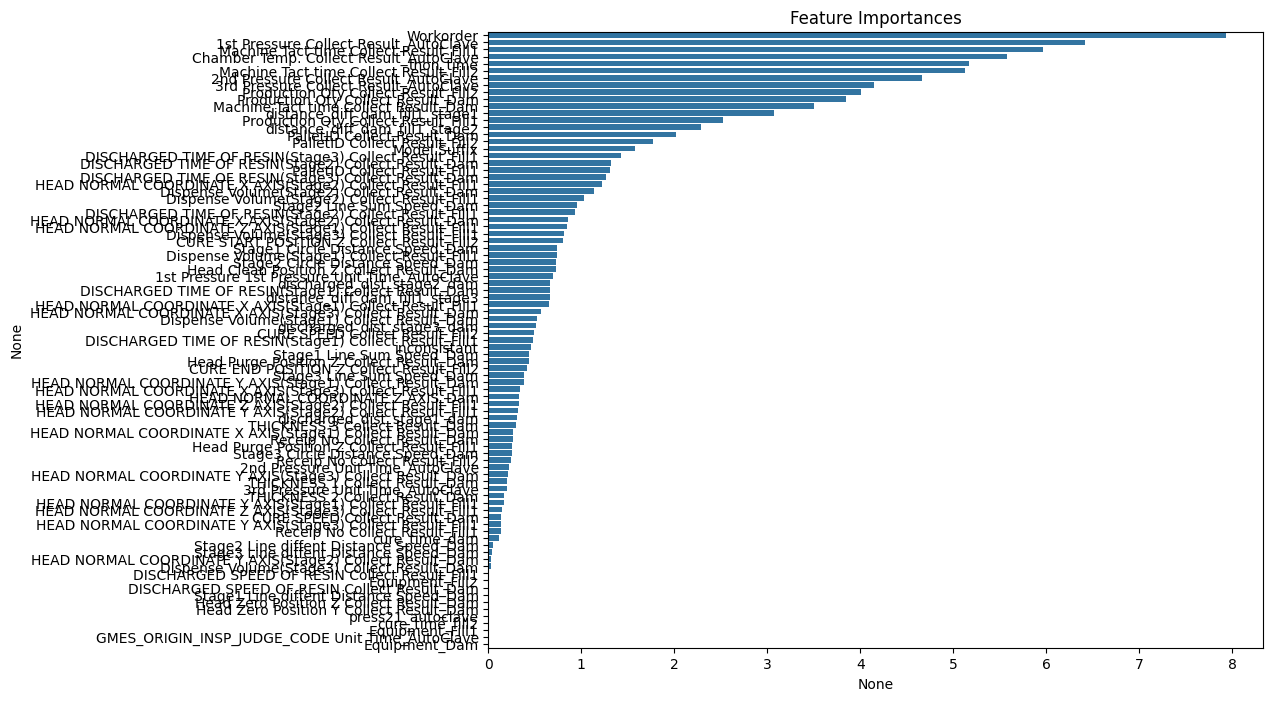

In [441]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [442]:
pred = cat_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  90  368]
 [ 324 7320]]

정확도: 0.9146
정밀도: 0.2174
재현율: 0.1965
F1: 0.2064


In [443]:
# Precision - Recall
y_pred_proba = cat_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  92  366]
 [ 327 7317]]

정확도: 0.9145
정밀도: 0.2196
재현율: 0.2009
F1: 0.2098


In [444]:
proba1 = y_pred_proba

### LGBM

In [463]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Workorder', 'Model.Suffix']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'float'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    lgbm_train[column] = lgbm_train[column].astype(dtype)
    lgbm_test[column] = lgbm_test[column].astype(dtype)
    
dtype = 'category'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    lgbm_train[column] = lgbm_train[column].astype(dtype)
    lgbm_test[column] = lgbm_test[column].astype(dtype)

In [464]:
X = lgbm_train.drop(columns=['target'])
y = lgbm_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

cat_features_indices = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder'] + columns_to

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    lgbm_params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
        "max_depth": trial.suggest_int('max_depth', 3, 63),
        "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
        "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
        "subsample": trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
        "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    }

    model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

    # 범주형 피처 적용
    model.fit(X_train, y_train, categorical_feature=cat_features_indices)

    # 검증 데이터에서 예측 수행
    y_pred = model.predict(X_valid)

    # F1 점수 계산
    f1 = f1_score(y_valid, y_pred)

    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-17 14:46:17,060] A new study created in memory with name: no-name-50dff194-96af-4e2c-9987-995d40be8e90
[I 2024-08-17 14:46:21,269] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 931, 'max_depth': 9, 'learning_rate': 0.0004684670932963348, 'reg_alpha': 0.07533064268599311, 'reg_lambda': 0.008423329001743763, 'min_child_weight': 2.650062784368869, 'min_child_samples': 98, 'subsample': 0.40830517775443353, 'subsample_freq': 2, 'colsample_bytree': 0.8033677879525076, 'num_leaves': 46}. Best is trial 0 with value: 0.0.
[I 2024-08-17 14:46:25,475] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 948, 'max_depth': 9, 'learning_rate': 0.0005413370117987624, 'reg_alpha': 0.02338566752828795, 'reg_lambda': 0.004224816460213293, 'min_child_weight': 1.6380059996414937, 'min_child_samples': 28, 'subsample': 0.5337634405036729, 'subsample_freq': 1, 'colsample_bytree': 0.28285762764500433, 'num_leaves': 33}. Best is trial 0 with value: 0.0.
[I 2024-08-17

[I 2024-08-17 14:47:57,720] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1083, 'max_depth': 28, 'learning_rate': 0.00012639324786393368, 'reg_alpha': 0.017112007698829007, 'reg_lambda': 0.016315027171930334, 'min_child_weight': 3.6123833918264703, 'min_child_samples': 5, 'subsample': 0.8628474675086011, 'subsample_freq': 5, 'colsample_bytree': 0.7364545928345618, 'num_leaves': 38}. Best is trial 16 with value: 0.12269938650306748.
[I 2024-08-17 14:48:06,897] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 1365, 'max_depth': 18, 'learning_rate': 0.00022462372322391215, 'reg_alpha': 0.011130223390350233, 'reg_lambda': 0.0012070371369317363, 'min_child_weight': 0.5687032918118857, 'min_child_samples': 26, 'subsample': 0.9338557805838866, 'subsample_freq': 3, 'colsample_bytree': 0.5178394959351308, 'num_leaves': 58}. Best is trial 16 with value: 0.12269938650306748.
[I 2024-08-17 14:48:13,371] Trial 20 finished with value: 0.013015184381778741 and p

[I 2024-08-17 14:50:07,399] Trial 36 finished with value: 0.12195121951219512 and parameters: {'n_estimators': 1315, 'max_depth': 38, 'learning_rate': 0.006048628105577147, 'reg_alpha': 0.00816632579274072, 'reg_lambda': 0.08025019080202941, 'min_child_weight': 3.295833839701186, 'min_child_samples': 69, 'subsample': 0.7716098953968263, 'subsample_freq': 3, 'colsample_bytree': 0.7724580697213013, 'num_leaves': 60}. Best is trial 16 with value: 0.12269938650306748.
[I 2024-08-17 14:50:13,799] Trial 37 finished with value: 0.1111111111111111 and parameters: {'n_estimators': 1021, 'max_depth': 21, 'learning_rate': 0.003715199254079802, 'reg_alpha': 0.24322922392833093, 'reg_lambda': 1.7090834022877717, 'min_child_weight': 1.5348981269214508, 'min_child_samples': 53, 'subsample': 0.8211672821435119, 'subsample_freq': 5, 'colsample_bytree': 0.6267631364317947, 'num_leaves': 54}. Best is trial 16 with value: 0.12269938650306748.
[I 2024-08-17 14:50:21,469] Trial 38 finished with value: 0.0 a

Best trial:
  Value: 0.1257606490872211
  Params: 
    n_estimators: 1264
    max_depth: 49
    learning_rate: 0.007541873648354692
    reg_alpha: 0.8346631808477174
    reg_lambda: 0.0019146338318209132
    min_child_weight: 3.108180471521674
    min_child_samples: 60
    subsample: 0.5853494246697006
    subsample_freq: 0
    colsample_bytree: 0.8059915095340463
    num_leaves: 29


In [465]:
lgbm_best_params = study.best_trial.params
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train, y_train, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.8059915095340463,
               learning_rate=0.007541873648354692, max_depth=49,
               min_child_samples=60, min_child_weight=3.108180471521674,
               n_estimators=1264, num_leaves=29, random_state=42,
               reg_alpha=0.8346631808477174, reg_lambda=0.0019146338318209132,
               subsample=0.5853494246697006)

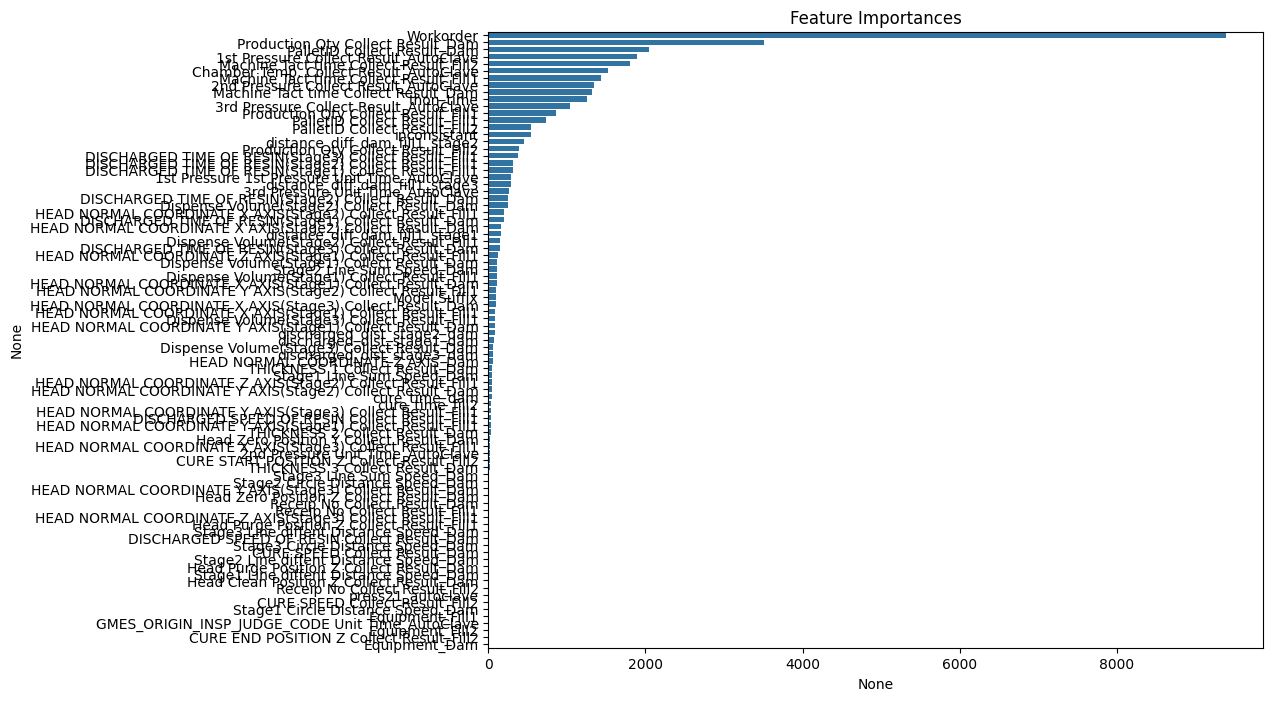

In [466]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [467]:
pred = lgbm_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  31  427]
 [   4 7640]]

정확도: 0.9468
정밀도: 0.8857
재현율: 0.0677
F1: 0.1258


In [468]:
# Precision - Recall
y_pred_proba = lgbm_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
lgbm_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= lgbm_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  80  378]
 [ 156 7488]]

정확도: 0.9341
정밀도: 0.3390
재현율: 0.1747
F1: 0.2305


In [469]:
proba2 = y_pred_proba

# XGB

In [470]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Workorder', 'Model.Suffix']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'float'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    xgb_train[column] = xgb_train[column].astype(dtype)
    xgb_test[column] = xgb_test[column].astype(dtype)

In [471]:
X = xgb_train.drop(columns=['target'])
y = xgb_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

cat_features_indices = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder'] + columns_to

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }

    model = xgb.XGBClassifier(eval_metric='logloss', **params)
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds)
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-17 14:51:11,062] A new study created in memory with name: no-name-383354b7-47da-4c5a-88e8-a6b861abc5fd
[I 2024-08-17 14:51:13,125] Trial 0 finished with value: 0.1381957773512476 and parameters: {'n_estimators': 293, 'max_depth': 4, 'learning_rate': 0.26220344372414744, 'subsample': 0.6126382994351971, 'colsample_bytree': 0.874444501532849, 'gamma': 1.286589139391483, 'lambda': 0.1678936624274691, 'alpha': 0.002445154582120258}. Best is trial 0 with value: 0.1381957773512476.
[I 2024-08-17 14:51:17,712] Trial 1 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 664, 'max_depth': 4, 'learning_rate': 0.03169679857481291, 'subsample': 0.6933016614955191, 'colsample_bytree': 0.6291626419479746, 'gamma': 0.1600983029851638, 'lambda': 0.014747752946587204, 'alpha': 5.108773640048106}. Best is trial 0 with value: 0.1381957773512476.
[I 2024-08-17 14:51:23,039] Trial 2 finished with value: 0.12219959266802444 and parameters: {'n_estimators': 866, 'max_depth': 

[I 2024-08-17 14:52:22,339] Trial 22 finished with value: 0.16393442622950818 and parameters: {'n_estimators': 168, 'max_depth': 9, 'learning_rate': 0.4497759785230782, 'subsample': 0.5239553345115238, 'colsample_bytree': 0.6987840262191289, 'gamma': 1.0933771940468562, 'lambda': 0.5138182378071232, 'alpha': 1.2306831129594977}. Best is trial 14 with value: 0.17102966841186737.
[I 2024-08-17 14:52:23,345] Trial 23 finished with value: 0.17488076311605724 and parameters: {'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.5725948786729949, 'subsample': 0.6485028764305314, 'colsample_bytree': 0.731165421710342, 'gamma': 1.9796011315246815, 'lambda': 0.5885606651458797, 'alpha': 0.45060999160629667}. Best is trial 23 with value: 0.17488076311605724.
[I 2024-08-17 14:52:25,107] Trial 24 finished with value: 0.13815789473684212 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.4959351806151787, 'subsample': 0.5102940012144049, 'colsample_bytree': 0.71807155961148

[I 2024-08-17 14:53:19,491] Trial 44 finished with value: 0.1579961464354528 and parameters: {'n_estimators': 577, 'max_depth': 6, 'learning_rate': 0.29817637125373825, 'subsample': 0.6862035882777162, 'colsample_bytree': 0.8916508965997648, 'gamma': 1.8011431443193537, 'lambda': 9.439406074349783, 'alpha': 0.1736349094327047}. Best is trial 35 with value: 0.17713365539452497.
[I 2024-08-17 14:53:23,342] Trial 45 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 517, 'max_depth': 7, 'learning_rate': 0.01251941535487939, 'subsample': 0.8106224017346347, 'colsample_bytree': 0.7542160347206763, 'gamma': 2.674445765644212, 'lambda': 2.3779725944400583, 'alpha': 0.09140533573374882}. Best is trial 35 with value: 0.17713365539452497.
[I 2024-08-17 14:53:25,490] Trial 46 finished with value: 0.1450980392156863 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.18359462450301361, 'subsample': 0.7366798430075385, 'colsample_bytree': 0.86237568797414

Best trial:
  Value: 0.17713365539452497
  Params: 
    n_estimators: 408
    max_depth: 7
    learning_rate: 0.4019083733262963
    subsample: 0.5783898066626535
    colsample_bytree: 0.734325682581576
    gamma: 1.253622879333253
    lambda: 0.7540924695985934
    alpha: 0.061993079163086176


In [472]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params = study.best_trial.params
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train, y_train)

XGBClassifier(alpha=0.061993079163086176, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.734325682581576, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.253622879333253,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.7540924695985934,
              learning_rate=0.4019083733262963, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=408, n_jobs=None, ...)

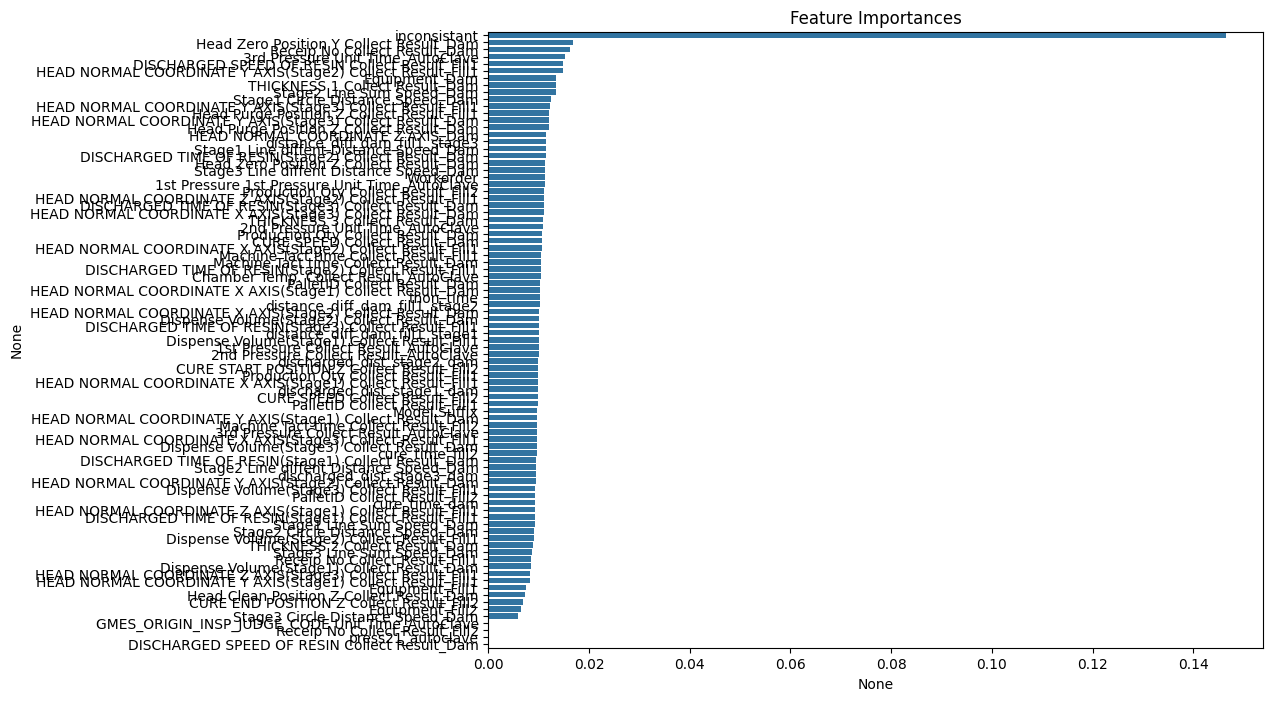

In [473]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [474]:
pred = xgb_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  55  403]
 [ 108 7536]]

정확도: 0.9369
정밀도: 0.3374
재현율: 0.1201
F1: 0.1771


In [475]:
# Precision - Recall

y_pred_proba = xgb_best_model.predict_proba(X_valid)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  83  375]
 [ 319 7325]]

정확도: 0.9143
정밀도: 0.2065
재현율: 0.1812
F1: 0.1930


In [476]:
proba3 = y_pred_proba

### Voting 실험

In [477]:
y_1_2 = proba1 + proba2 / 2
y_1_3 = proba1 + proba3 / 2
y_2_3 = proba2 + proba3 / 2
y_1_2_3 = proba1 + proba2 + proba3 / 3

In [512]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_1_2)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold_1 = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold_1 = (y_1_2 >= best_threshold_1).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold_1)

오차행렬:
 [[  76  382]
 [ 197 7447]]

정확도: 0.9285
정밀도: 0.2784
재현율: 0.1659
F1: 0.2079


In [513]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_1_3)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold_2 = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_1_3 >= best_threshold_2).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold_2)

오차행렬:
 [[  80  378]
 [ 156 7488]]

정확도: 0.9341
정밀도: 0.3390
재현율: 0.1747
F1: 0.2305


In [510]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_2_3)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_2_3 >= best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  99  359]
 [ 311 7333]]

정확도: 0.9173
정밀도: 0.2415
재현율: 0.2162
F1: 0.2281


In [519]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_1_2_3)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold_3 = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_1_2_3 >= best_threshold_3).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  75  383]
 [ 177 7467]]

정확도: 0.9309
정밀도: 0.2976
재현율: 0.1638
F1: 0.2113


In [482]:
proba1

array([0.09300731, 0.05019336, 0.078894  , ..., 0.37921505, 0.34077921,
       0.13640901])

In [483]:
best_f1 = 0
best_weights = None

# 가중치 조합 테스트
for w1 in range(1, 6):
    for w2 in range(1, 6):
        for w3 in range(1, 6):
            # 가중 평균 계산
            final_proba = (w1 * proba1 + w2 * proba2 + w3 * proba3) / (w1 + w2 + w3)
            precision, recall, thresholds = precision_recall_curve(y_valid, final_proba)
            f1_scores = 2*recall*precision / (recall + precision)
            best_threshold = thresholds[np.argmax(f1_scores)]
            y_pred = (y_1_2_3 >= best_threshold).astype(int)
#             y_pred = (final_proba[:] > 0.5).astype(int)
            
            # F1 스코어 계산
            f1 = f1_score(y_valid, y_pred, average='binary')
            
            print(f1)
            
            # 최고 성능 저장
            if f1 > best_f1:
                best_f1 = f1
                best_weights = (w1, w2, w3)

print("Best F1 Score: ", best_f1)
print("Best Weights: ", best_weights)

0.1530398322851153
0.15495495495495495
0.15540296349837368
0.13537117903930132
0.13719131953105512
0.13997821350762527
0.13909774436090225
0.13374146456322109
0.13264203931734717
0.13355048859934854
0.13471741637831602
0.13964686998394862
0.13498688290007155
0.13324764353041987
0.13296979865771813
0.1333955223880597
0.13789473684210526
0.1342837433892849
0.13157305884985454
0.13283208020050125
0.14574187884108866
0.14234083958854601
0.134372850263701
0.1314260169870362
0.1333907056798623
0.16472617507546355
0.15434083601286175
0.1566994700984103
0.15880693268843207
0.15752351097178682
0.15071283095723015
0.1530398322851153
0.14672754946727548
0.15495495495495495
0.13725006171315723
0.14665057332528667
0.14612146722790137
0.1399132321041215
0.13964686998394862
0.137859549105986
0.1469135802469136
0.13997821350762527
0.14281729428172943
0.13909774436090225
0.13729977116704806
0.13839400981151562
0.1444954128440367
0.13782219884271435
0.1357421875
0.13500482160077146
0.16970327954190526
0

In [485]:
y_best = best_weights[0] * proba1 + best_weights[1] * proba2 + best_weights[2] * proba3 / best_weights[0] + best_weights[1] + best_weights[2]

In [486]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_best)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  91  367]
 [ 321 7323]]

정확도: 0.9151
정밀도: 0.2209
재현율: 0.1987
F1: 0.2092


In [487]:
y_pred_custom_threshold_1 = (proba1 >= cat_best_threshold).astype(int)
y_pred_custom_threshold_2 = (proba2 >= lgbm_best_threshold).astype(int)
y_pred_custom_threshold_3 = (proba3 >= best_threshold).astype(int)

result1 = np.logical_or(y_pred_custom_threshold_1, y_pred_custom_threshold_2)
result2 = np.logical_or(y_pred_custom_threshold_1, y_pred_custom_threshold_3)
result3 = np.logical_or(y_pred_custom_threshold_2, y_pred_custom_threshold_3)
result4 = np.logical_or(y_pred_custom_threshold_2, y_pred_custom_threshold_3)
result4 = np.logical_or(result4, y_pred_custom_threshold_1)

get_clf_eval(y_valid, result1)

오차행렬:
 [[ 115  343]
 [ 433 7211]]

정확도: 0.9042
정밀도: 0.2099
재현율: 0.2511
F1: 0.2286


In [488]:
get_clf_eval(y_valid, result2)

오차행렬:
 [[  92  366]
 [ 327 7317]]

정확도: 0.9145
정밀도: 0.2196
재현율: 0.2009
F1: 0.2098


In [489]:
get_clf_eval(y_valid, result3)

오차행렬:
 [[  80  378]
 [ 156 7488]]

정확도: 0.9341
정밀도: 0.3390
재현율: 0.1747
F1: 0.2305


In [490]:
get_clf_eval(y_valid, result4)

오차행렬:
 [[ 115  343]
 [ 433 7211]]

정확도: 0.9042
정밀도: 0.2099
재현율: 0.2511
F1: 0.2286


# 학습 후 예측 및 제출용 데이터 생성

In [491]:
set_id = pd.read_csv('test_df.csv')
cat_test = pd.concat([cat_test, set_id['Set ID']], axis = 1)
xgb_test = pd.concat([xgb_test, set_id['Set ID']], axis = 1)
lgbm_test = pd.concat([lgbm_test, set_id['Set ID']], axis = 1)

### Catboost

In [493]:
cat_test_pool = Pool(data=cat_test.drop(columns='Set ID'), cat_features=cat_features_indices)

In [494]:
cat_pred = cat_best_model.predict(cat_test.drop(columns='Set ID'))

In [495]:
sum(cat_pred)

999

In [496]:
cat_pred_proba = cat_best_model.predict_proba(cat_test.drop(columns='Set ID'))[:, 1]

In [497]:
sum(cat_pred_proba)

2772.402911051092

In [525]:
y_pred_cat = (cat_pred_proba >= cat_best_threshold).astype(int)

### LGBM

In [498]:
lgbm_pred = lgbm_best_model.predict(lgbm_test.drop(columns='Set ID'))

In [499]:
sum(lgbm_pred)

77

In [500]:
lgbm_pred_proba = lgbm_best_model.predict_proba(lgbm_test.drop(columns='Set ID'))[:, 1]

In [501]:
sum(lgbm_pred_proba)

1057.8408271780288

In [526]:
y_pred_lgbm = (lgbm_pred_proba >= lgbm_best_threshold).astype(int)

### XGB

In [502]:
xgb_pred = xgb_best_model.predict(xgb_test.drop(columns='Set ID'))

In [503]:
xgb_pred_proba = xgb_best_model.predict_proba(xgb_test.drop(columns='Set ID'))[:, 1]

### Voting

In [504]:
y_pead_1_2 = cat_pred_proba + lgbm_pred_proba / 2
y_pred_1_3 = cat_pred_proba + xgb_pred_proba / 2
y_pred_2_3 = lgbm_pred_proba + xgb_pred_proba / 2
y_pred_1_2_3 = cat_pred_proba + lgbm_pred_proba + xgb_pred_proba / 3

In [520]:
y_pred_custom_threshold = (y_pred_1_2_3 >= best_threshold_3).astype(int)

### 데이터 결정 및 결합

In [521]:
result = y_pred_custom_threshold

In [522]:
y_pred = np.where(result == 0, "Normal", "AbNormal")

In [523]:
y_pred

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype='<U8')

In [524]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)